# Geodesic Integration Demo with FADGE
### [Originally written](https://github.com/adxsrc/fadge/blob/main/demos/geode.ipynb) by Chi-kwan "CK" Chan
### Updated by Tintin Nguyen, February 21, 2024

**FADGE introduction**

[FADGE](https://github.com/adxsrc/fadge) is a Python differential geometry package built on top of Google's [JAX](https://github.com/google/jax), a machine learning framework for efficient numerical computing. The purpose of FADGE is to do geodesic integration in general relativity, using the numerical integration package [XAJ](https://github.com/adxsrc/xaj). 

FADGE and XAJ are part of a larger JAX-based numerical relativity suite called [ADXSRC](https://github.com/adxsrc). Currently, ADXSRC only supports numerical integration (XAJ) and geodesic integration (FADGE), but in the near future, ADXSRC hopes to expand to radiative transfer and fluid simulation for full general relativistic ray tracing capacity. ADXSRC is being developed by [Chi-kwan "CK" Chan](http://rndsrc.dev).

**Numerical integration method**

XAJ implements the [Dormant-Prince 4(5)](https://en.wikipedia.org/wiki/Dormand–Prince_method) method to numerically solve for differential equations. Dormant-Prince 4(5) is an *adaptive stepsize* algorithm, a subclass of the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge–Kutta_methods). The idea is to calculate both 4th-order and 5th-order approximated solutions, instead of just the 4th-order one in the regular Runge-Kutta 4th-order scheme. The difference between the 4th and 5th-order solution will be considered as an 'error'. If this 'error' is too big (i.e. larger than a certain threshold that we select), we would try a smaller integration stepsize and repeat the process until the 'error' is smaller than our chosen threshold.

In our context of ray tracing around black hole, when the photon is far away from the black hole, it can take a large stepsize because it's mostly moving straight without much influence from the black hole. However, when the photon gets closer to the black hole, the influence from the black hole's gravity starts to become dominant, causing our 'error' to grow, so the algorithm knows to reduce the integration stepsize to maintain the desired precision.

Note that Runge-Kutta numerical methods do not care about the physics - it's just an approximation of solutions to differential equations purely based on mathematics. If naively implemented, Runge-Kutta methods can lead to unphysical results, such as violation of energy conservation (e.g. a planet spirals into the Sun rather than stably orbits). In FADGE, we add a physical constraint to the numerical algorithm: the photons have to remain massless by keeping $u^{\mu} u_{\mu} = 0$, where $u^{\mu}$ is the photon's velocity vector. (Side, unrelevant note: the interested reader can look into [symplectic integrators](https://en.wikipedia.org/wiki/Symplectic_integrator) for numerical methods that actively conserve energy by considering the Hamiltonian of the system)

For more information, refer to Chapter 17 of the ["Numerical Recipes, 3rd Edition,"](http://numerical.recipes/book.html) especially section 17.2 on "Adaptive Stepsize Control for Runge-Kutta." CK also has an introduction to numerical integration of differential equations [module](https://github.com/uarizona-2021spring-phys105a/phys105a/blob/main/12/ode2.ipynb) as part of his Introduction to Scientific Computing course. 

**Now, let's start with the demo!**

Note that throughout this notebook, we set $G = c = M = 1$, so that our parameters (i.e. distance in unit of $GM/c^2$ and time in unit of $GM/c^3$) are dimensionless. 

First, we import the necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

from fadge import GRRT
from jax   import numpy as np

from matplotlib import pyplot as plt
from itertools  import product

We then create an object with `GRRT`, which sets up the black hole spin $a$ and charge $q$ (denoted as variable `aspin` and `qcharge` in the code) in the Kerr-Newman spacetime, where the metric in both Boyer-Lindquist and Cartesian Kerr-Schild coordinates can be found in [Wikipedia](https://en.wikipedia.org/wiki/Kerr–Newman_metric). The Kerr-Newman metric describes a black hole when $a^2 + q^2 \leq 1$, and when $a^2 + q^2 > 1$, the event horizon vanishes, leaving behind a naked singularity.

The input `atol` and `rtol` represent the absolute and relative tolerance, relatively. These tolerance values are the error threshold in the numerical method we discuss above. The difference between these two tolerance concepts is that the relative tolerance is relative to the 4th and 5th-order solution, e.g. we want to be within 1% of the solution. Meanwhile, the absolute tolerance is a straightforward value without any reference to other quantities, e.g. we want the error to be less than 0.001. Note that the relative tolerance can be pretty tricky: for a given relative tolerance, a larger solution allows for a larger error. For the example below, we set `atol=1e-3` and `rtol=0` to say that we want the error to be less than 0.001 and we don't care about the relative tolerance. 

In [2]:
grrt_test = GRRT(aspin=0.9375, qcharge = 0.2, atol=1e-3, rtol=0, names={'ind':'lambda'})

Radius of outer event horizon: 1.2847697


To setup the initial conditions, we first set the camera location using `object.set_cam`, and then specify the image plane (i.e. our "camera") using `object.set_image`.

First, let's visualize our Cartesian Kerr-Schild coordinates. The center of the black hole is set at the origin. The ring singularity of the black hole is oriented on the $x$-$y$ plane, and the $z$-axis is perpendicular to the ring singularity. The Cartesian coordinates on the image plane is denoted as the $\alpha$-$\beta$ plane.

`object.set_cam` has 3 inputs: $R, i, \phi$ (the same order in the code input). $R$ is the distance from the origin to the image plane. We're interested in observational signatures of black holes as a faraway observer, so we set $R$ as a very big number, 10,000 in our case. $i$ is the inclination angle with respect to the $z$-axis. $i = 0^{\circ}$ means we're looking at the black hole face-on, and $i = 90^{\circ}$ is edge-on. $\phi$ is the polar angle, which doesn't matter due to the axisymmetry of the Kerr-Newman spacetime, so we just set $\phi = 0^{\circ}$ without loss of generality. ($R, i, \phi$) form the typical 'spherical coordinates' that we're used to in regular space.

`object.set_image` initializes a grid of photons whose geodesics will be integrated towards the black hole. `set_image` has 2 inputs: size of the square image plane and number of gridded photons on each row or column of the image plane. It's probably easier to visualize what `set_image` does when you look at the figure below. Note that the photons are located at the center of the image plane grid, not at the edges.

<p align="center">
  <img src="fadge_geom.png" alt="drawing" width="600"/>
</p>

In [3]:
grrt_test.set_cam(1e4, 0, 0)
grrt_test.set_image(6, 3)

print('Array shape of the initial conditions:', grrt_test._ic.shape)

Array shape of the initial conditions: (2, 4, 3, 3)


After `object.set_cam` and `object.set_image`, we have an initial array of photons, encoded in `object._ic`. This has 4 dimensions:
- First index: 0 and 1 represent position and velocity vector, respectively
- Second index: 0, 1, 2, 3 represent (t, x, y, z) coordinates in Cartesian Kerr-Schild (note that for photons, t is not 'proper time' because photons don't 'experience' time; t is instead a parameter called 'affine parameter')
- Third index and fourth index represent the photon grid

Let's look at a simple example `grrt_test` object, where we have a 3x3 grid on an image plane of length 6 and we're observing the black hole face-on ($i = 0^{\circ}$). We first look at the position vector, so the first input of the `object._ic` is 0. When we slice this array as `object._ic[0, k]`, it outputs a 3x3 array representing the k-component of the initial position vector for the 3x3 photon grid.

At face-on inclination, the radial distance from the origin is the $z$-coordinate, which is 10,000 in our case. The $\alpha$-$\beta$ image plane is a projection of the $x$-$y$ plane. As you've seen in the geometric visualization above, the photons are located at coordinates -2, 0, and 2 in the $\alpha$-$\beta$ plane, so this is reflected in the $x$ and $y$ coordinates.

In [4]:
coord = ["t", "x", "y", "z"]

In [5]:
print("Initial position vector")
print("")
for k in range(4):
    print("second index =", k)
    print("coordinate:", coord[k])
    print(grrt_test._ic[0, k].round(2))
    print("")

Initial position vector

second index = 0
coordinate: t
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

second index = 1
coordinate: x
[[ 2.  0. -2.]
 [ 2.  0. -2.]
 [ 2.  0. -2.]]

second index = 2
coordinate: y
[[-2. -2. -2.]
 [ 0.  0.  0.]
 [ 2.  2.  2.]]

second index = 3
coordinate: z
[[10000. 10000. 10000.]
 [10000. 10000. 10000.]
 [10000. 10000. 10000.]]



Now, let's look at the velocity vector. The only change here is that the first input of the `object._ic` is 1. We see that since the photons are only traveling in the $z$-direction, the $x$ and $y$ components of velocity are 0. The speed of light $c$ is set equal to 1, so the $z$-velocity is 1. Also, since velocity vectors (denoted as $u^{\mu}$) of light are null vectors, $u^{\mu} u_{\mu} = g_{\mu \nu} u^{\mu} u^{\nu} = 0$. Faraway from the black hole, the metric is flat (Minkowski) so $g^{\mu \nu} =$ diag $(-1, 1, 1, 1)$. $g_{\mu \nu} u^{\mu} u^{\nu} = -(u^{t})^2 + (u^{z})^2 = -(u^{t})^2 + 1 = 0$, so $u^{t} = 1$.

In [6]:
print("Initial velocity vector")
print("")
for k in range(4):
    print("second index =", k)
    print("coordinate:", coord[k])
    print(grrt_test._ic[1, k].round(2))
    print("")

Initial velocity vector

second index = 0
coordinate: t
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

second index = 1
coordinate: x
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

second index = 2
coordinate: y
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

second index = 3
coordinate: z
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]



Now, let's examine a slightly more complicated setup, an inclination of $60^{\circ}$ and a 32x32 photon grid in a 16-size image plane.

In [7]:
grrt = GRRT(aspin=0.9375, qcharge = 0.2, atol=1e-3, rtol=0, names={'ind':'lambda'})

Radius of outer event horizon: 1.2847697


In [8]:
grrt.set_cam(1e4, 60, 0)
grrt.set_image(16, 32)

print('Array shape of the initial conditions:', grrt._ic.shape)

Array shape of the initial conditions: (2, 4, 32, 32)


To perform geodesic integration, simply call `grrt.geode()`.
When no argument is specified, the integration is carried out to `-2 * r_obs`.
The return values are the full steps during the integration.

In [9]:
l, f = grrt.geode() # full step output

fx = f[:,0,1]
fy = f[:,0,2]
fz = f[:,0,3]

jit(masked_do); input: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> [Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,32,32])>with<DynamicJaxprTrace(level=0/1)>]


100%|████████████████████████████████████████████████████| 100/100 [00:31<00:00,  2.54it/s, lambda=-2.01e+04, dlambda=-2.28e+03]


target = -20000.0 exceeded; SKIP


Note that the output of the geodesic integration, f, is a 5-dimensional array. The first index denotes each step of the integration. The other indices are the same as the initial condition (position/velocity vector, coordinates, each photon on the grid).

In [10]:
f.shape

(7467, 2, 4, 32, 32)

Because `PRay` uses `XAJ` for solving ODEs, it supports dense output via interpolation between data points.
We can put a lot of sampling points near the black hole for better visualization of the geodesics.

In [11]:
l = np.linspace(-10100,-9900,201)
i = grrt.geode(l) # interpolate using dense output

ix = i[:,0,1]
iy = i[:,0,2]
iz = i[:,0,3]

target = -9900.0 exceeded; SKIP
target = -10100.0 exceeded; SKIP


In [12]:
i.shape

(201, 2, 4, 32, 32)

We are finally ready to plot the results.

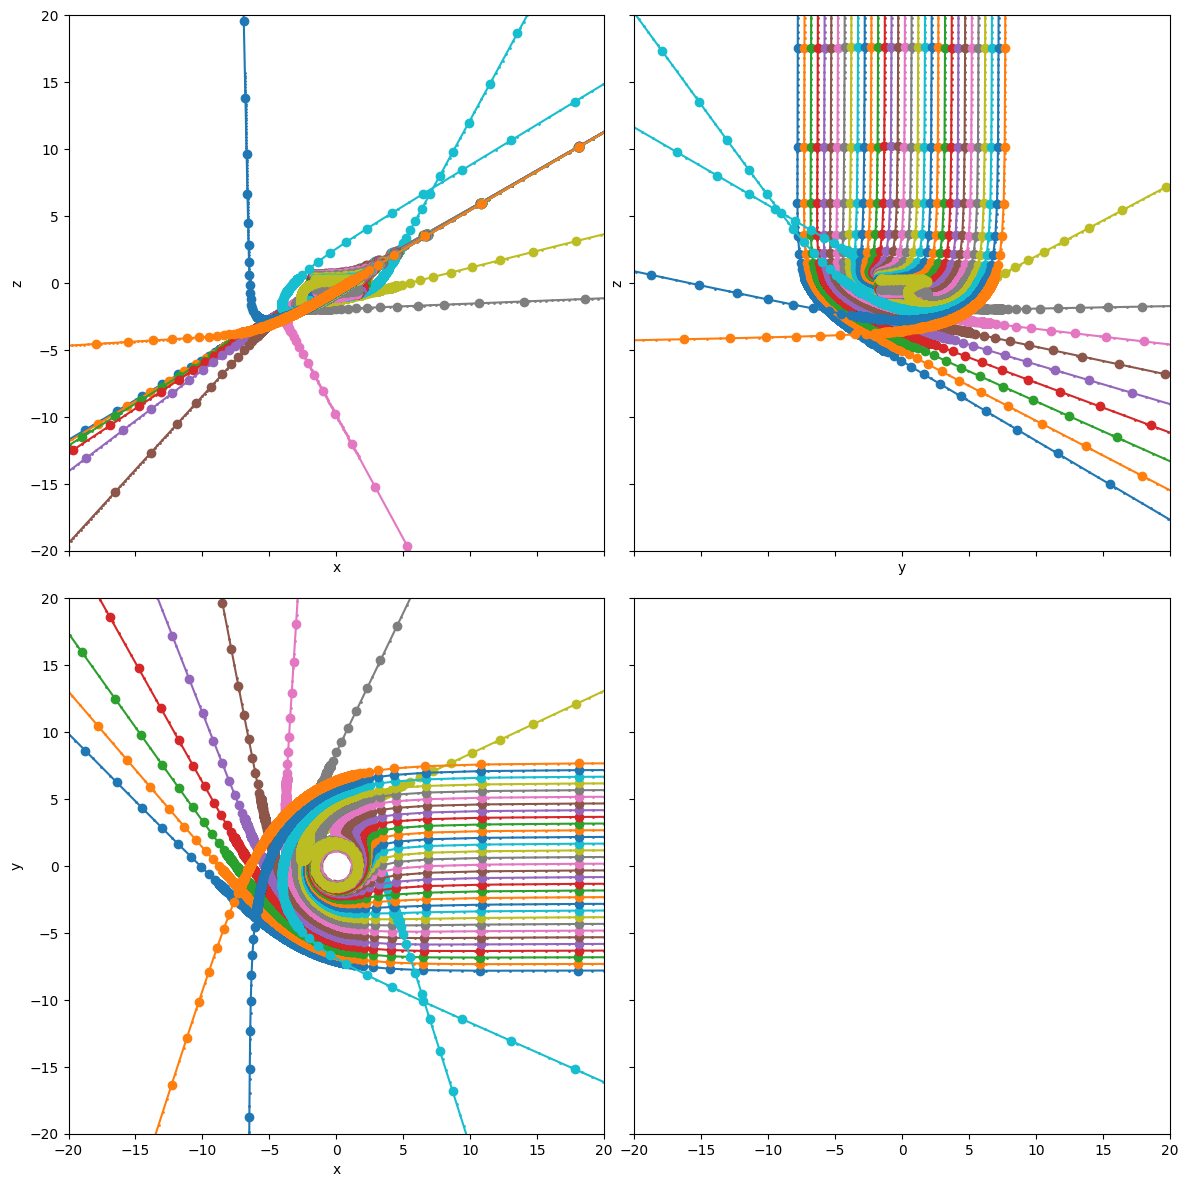

In [13]:
fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)

for i,j in product(range(32), range(15,16)):
    axes[0][0].plot(fx[:,i,j], fz[:,i,j], '-o', color=f'C{i}')
    axes[0][1].plot(fy[:,i,j], fz[:,i,j], '-o', color=f'C{i}')
    axes[1][0].plot(fx[:,i,j], fy[:,i,j], '-o', color=f'C{i}')
    axes[0][0].scatter(ix[:,i,j], iz[:,i,j], s=1, color=f'C{i}')
    axes[0][1].scatter(iy[:,i,j], iz[:,i,j], s=1, color=f'C{i}')
    axes[1][0].scatter(ix[:,i,j], iy[:,i,j], s=1, color=f'C{i}')

fig.tight_layout()

ax = axes[0][0]
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

ax = axes[0][1]
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

ax = axes[1][0]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

ax = axes[1][1]
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

Here we zoom in and show only the geodesics that reach the horizon.

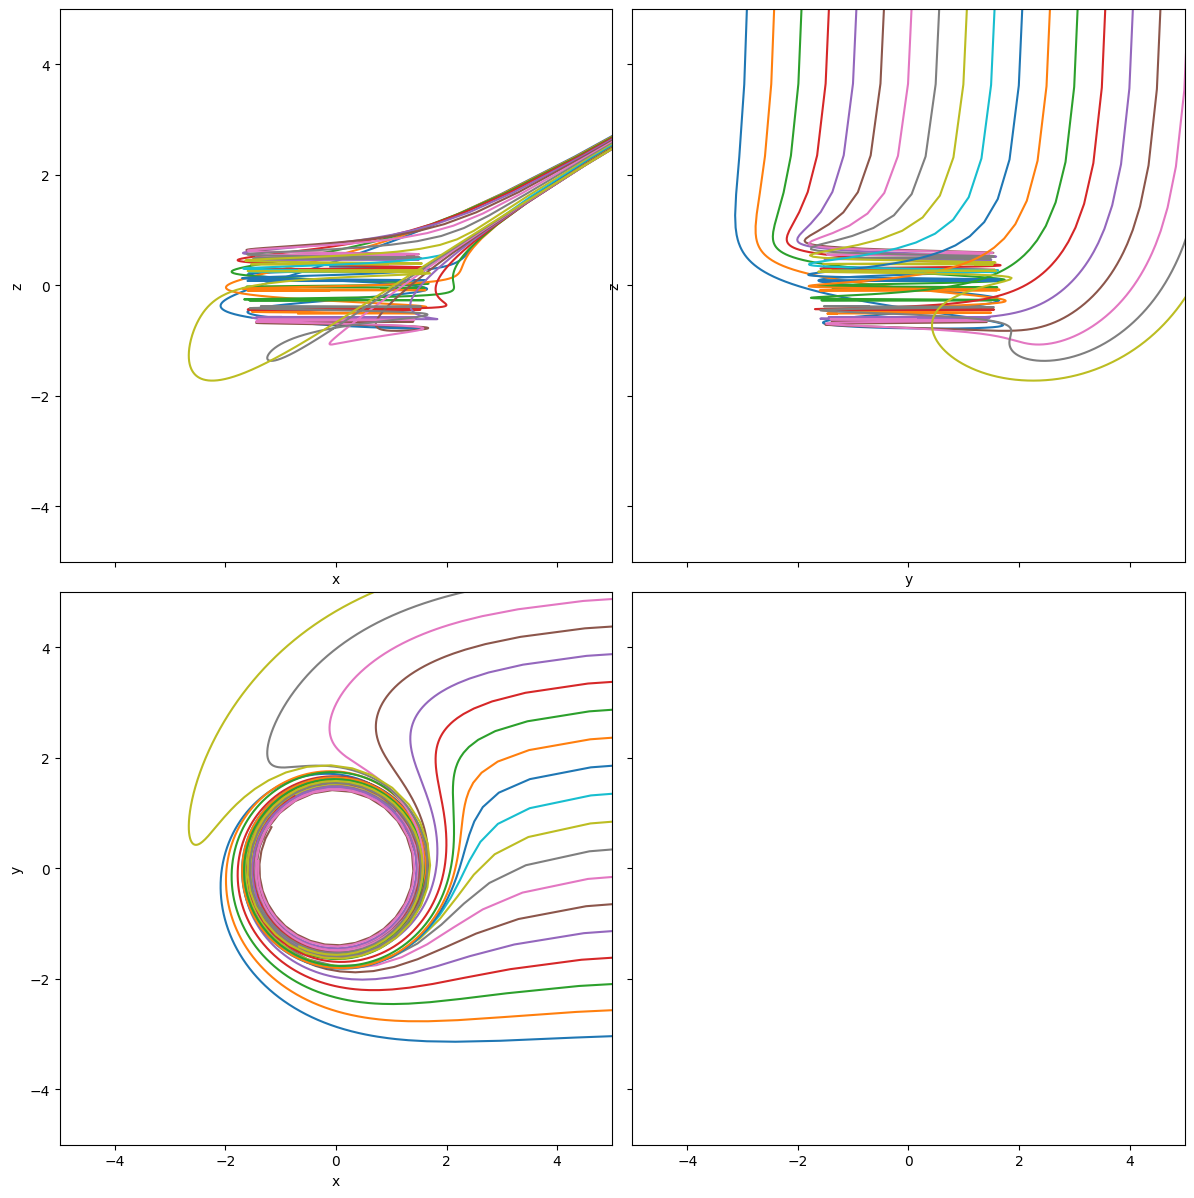

In [14]:
fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)

for i,j in product(range(10,29), range(15,16)):
    axes[0][0].plot(fx[:,i,j], fz[:,i,j], '-', color=f'C{i}')
    axes[0][1].plot(fy[:,i,j], fz[:,i,j], '-', color=f'C{i}')
    axes[1][0].plot(fx[:,i,j], fy[:,i,j], '-', color=f'C{i}')

fig.tight_layout()

ax = axes[0][0]
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

ax = axes[0][1]
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

ax = axes[1][0]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

ax = axes[1][1]
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')